In [4]:
from osgeo import gdal
import numpy as np
from tqdm import trange, tqdm
from scipy import interpolate
import random
from sklearn import model_selection, metrics

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
%run CDTM/functions_CDTM.py

In [8]:
%run technical_functions/geotransform_functions.py

In [9]:
%run technical_functions/ImageToNgs.py

In [10]:
%run technical_functions/cv_and_reclassification.py

In [11]:
def image_to_tensor_interp(T, X_pan_filename, X_mult_filename, step = 4, window_size = 55):
    
    half_size = window_size // 2
    
    X_pan = gdal.Open(X_pan_filename)
    X_mult = gdal.Open(X_mult_filename)
  #  X_pan_rasterio = rxr.open_rasterio(X_pan_filename).squeeze()
  #  X_mult_rasterio = rxr.open_rasterio(X_mult_filename)
    
    m, n = X_pan.ReadAsArray().shape
    _, m_m, m_n = X_mult.ReadAsArray().shape
    
    geo_trans_pan = X_pan.GetGeoTransform()
    geo_trans_mult = X_mult.GetGeoTransform()
    proj_pan = X_pan.GetProjection()
    proj_mult = X_mult.GetProjection()
    
    #тут нужно сделать перевод пикселей мультиканалного изображения в пиксели одноканального изображения
    pixels_pan_list = []
    for i in range(1, m_m + 1):
        a = []
        for j in range(1, m_n + 1):
            a.append((i, j))
        a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
        a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
        pixels_pan_list.append(a_pixels_in_pan)
    #теперь в pixels_list лежат листы с пикселями каждой строки
    
    mesh = np.meshgrid(np.arange(0, m_n, step), np.arange(0, m_m, step))
    values = np.zeros((mesh[0].shape[0], mesh[0].shape[1], 5))
    
     #тут нужно отсимметрить все стороны тензора
    T_ = torch.tensor(T)
    upper_part = torch.flip(T_[0:half_size, :, :, :], [0])
    lower_part = torch.flip(T_[m - half_size:m, :, :, :], [0])
    T_ = torch.cat((upper_part, T_, lower_part), dim = 0)
    left_part = torch.flip(T_[:, 0:half_size, :, :], [1])
    right_part = torch.flip(T_[:, n-half_size:n, :, :], [1])
    T_ = torch.cat((left_part, T_, right_part), dim = 1)
    T_ = np.array(T_)
    
    
    for i in trange(0, len(pixels_pan_list), step): #m_m x m_n
        for j in range(0, len(pixels_pan_list[0]), step):
            x, y = pixels_pan_list[i][j]
            x = int(x + half_size - 1)
            y = int(y + half_size - 1)
            tmp = T_[x - half_size : x + half_size + 1, y - half_size:y + half_size + 1][:][:]
            CDTM_temp = build_CDTM(tmp, isSymmetric = True)
            props = CDTM_props(CDTM_temp)
            values[i // step, j // step, :] = props
            
    values_interpolated = np.zeros((m_m, m_n, 5))
    for i in range(5):
        f = interpolate.interp2d(np.arange(0, m_n, step), np.arange(0, m_m, step), values[:, :, i], kind = 'linear')
        x_ = np.arange(0, m_n)
        y_ = np.arange(0, m_m)
        values_interpolated[:, :, i] = f(x_, y_)
    return values, values_interpolated

In [13]:
img = gdal.Open('geotiff/Konstantinovky_TestReg_pan.tif')
T = CDTM(img.ReadAsArray(), Ngs = 64)

  0%|          | 0/1694 [00:00<?, ?it/s]

In [14]:
np.save('T_cdtm', T)

In [15]:
T.shape

(1694, 1793, 16, 2)

In [16]:
X_pan_filename = "geotiff/Konstantinovky_TestReg_pan.tif"
X_mult_filename = "geotiff/Konstantinovky_TestReg_mult.tif"

In [27]:
import sys
import warnings
warnings.filterwarnings("ignore")

In [17]:
v, v_i = image_to_tensor_interp(T, X_pan_filename, X_mult_filename)

  0%|          | 0/106 [00:00<?, ?it/s]

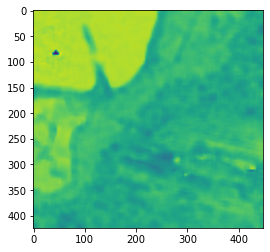

In [20]:
plt.imshow(v_i[:, :, 0])

In [21]:
T = v_i

In [22]:
np.any(np.isnan(T))

False

In [23]:
T.shape

(424, 448, 5)

Загружаем карту.

In [24]:
map_konst = gdal.Open('geotiff/Konstantinovsky_map.tif')
#konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult = konstantinovsky_mult_gdal.ReadAsArray()
map_values = map_konst.ReadAsArray()
#map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_values[i][j]
        cnt_j += 1
    cnt_i += 1

  0%|          | 0/424 [00:00<?, ?it/s]

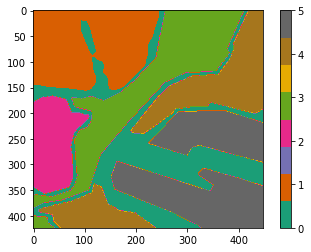

In [25]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [28]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(5):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

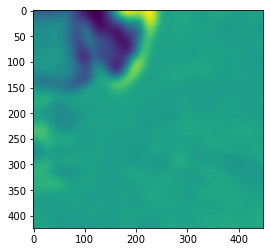

In [30]:
plt.imshow(T[:, :, 4])

In [32]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 5))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [33]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [34]:
data = np.concatenate((T, map_konst_), axis = 1)

In [35]:
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 10000))), axis = 0)

In [36]:
X = data_[:, :5]
y = data_[:, 5]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify = y) 

In [38]:
qda = QuadraticDiscriminantAnalysis()

In [39]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [40]:
pred_qda = qda.predict(T.reshape(424 * 448, 5))

In [41]:
p = pred_qda.reshape((424, 448))

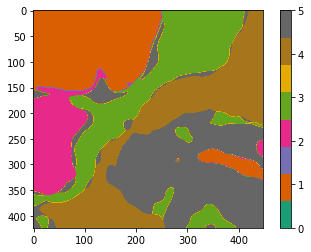

In [42]:
plt.imshow(pred_qda.reshape(424, 448), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [43]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt

(<pandas.io.formats.style.Styler at 0x7fca9e1f3950>,
 [  10-fold cross-validation                                       \
              Omission error Commission error Producer’s accuracy   
  1                 0.003120         0.003489            0.996880   
  2                 0.011987         0.011210            0.988013   
  3                 0.074658         0.128972            0.925342   
  4                 0.008777         0.024951            0.991223   
  5                 0.162952         0.091617            0.837048   
  
                     
    User’s accuracy  
  1        0.996511  
  2        0.988790  
  3        0.871028  
  4        0.975049  
  5        0.908383  ,
    Reclassification                                                     
      Omission error Commission error Producer’s accuracy User’s accuracy
  1         0.003131         0.003735            0.996869        0.996265
  2         0.011717         0.011318            0.988283        0.988682
  3       